In [8]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from binary_c_API import evolve_binary
import os

# mpl.rc('font',**{'family':'serif','serif':['Palatino']})
# mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

The goal of this notebook is to explore various initial conditions for the binary system and generate stellar data for it. There are 4 important parameters for the binary system: $M_1$, mass of star 1 (we use the subscript 1 for the more massive star), $M_2$, mass of star 2, and the initial orbital parameters $a$ and $e$. 

We want to choose several values of these parameters and then run NBODY simulation of planets around these stars as they evolve past the Main Sequence.

In [9]:
def final_configuration(df):
    """
    Iterates through the stellar evolution code output
    and prints important events and final parametars of the system.
    """
    
    final_conf = ["Convective low mass MS","MS","HG",
              "1st GB","CHeB","1st AGB",
              "2nd AGB","MS Naked Helium",
              "HG Naked Helium","GB Naked Helium",
              "Helium WD","C/O WD","O/N WD",
              "NS","BH","Massless"]
    
    print("Final configuration:\n",final_conf[int(df['type1'].iloc[-1])],"+",
          final_conf[int(df['type2'].iloc[-1])])
    
def select_rgb(df):
    """Slice the stellar evolution object such that it only consists of the rgb phase
    up to CE."""
    # Start when a or e drop by more than 5% from initial value
    i = 0
    while(df['a'].iloc[i] > df['a'].iloc[0]*(1 - 0.005) or\
          df['e'].iloc[i] > df['e'].iloc[0]*(1 - 0.005)):
        t0 = i
        i = i + 1
    
    # End when RLOF begins
    j = 0
    while(df['in_RLOF'].iloc[j] == 0):
        tf = j
        j = j + 1
        if not (j < len(df['t'].values) - 1):
            raise AssertionError("RLOF doesn't happen.")

    return df.iloc[t0:tf + 2]

First, we need to seperate the time during stellar evolution when appreciable semi-major axis and eccentricity evolution happens.

/home/fran/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


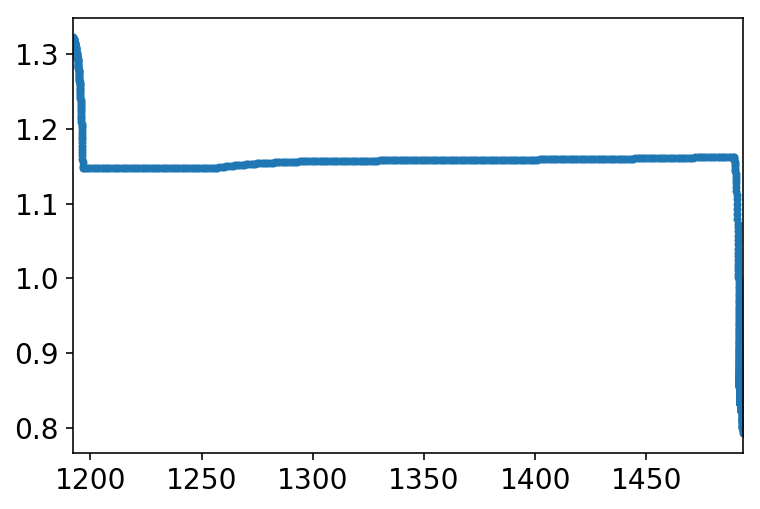

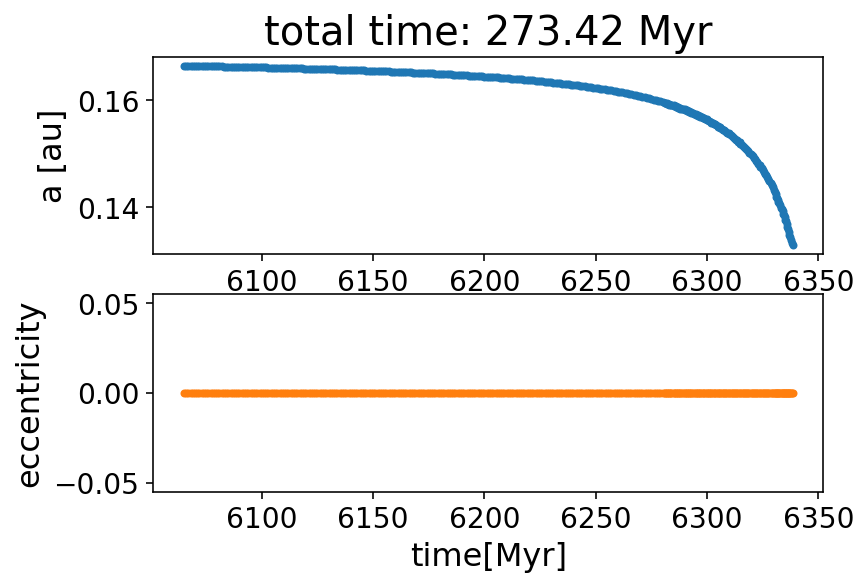

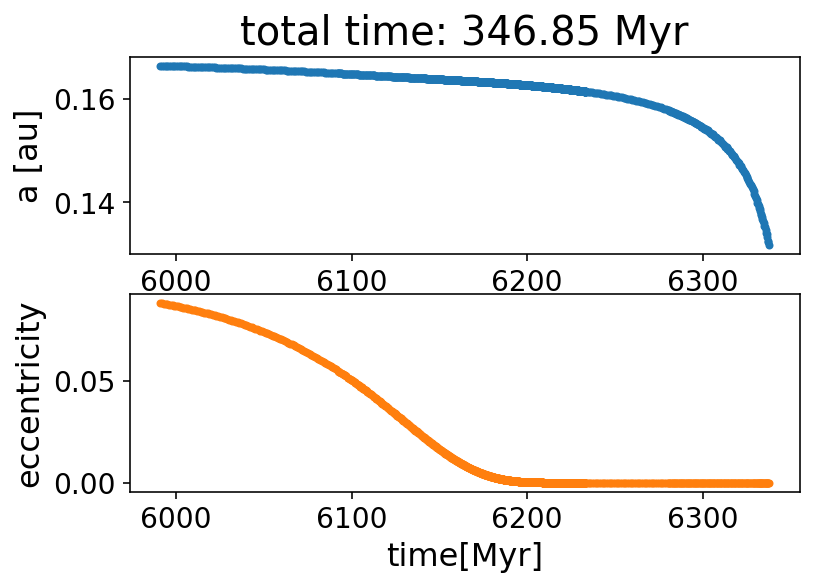

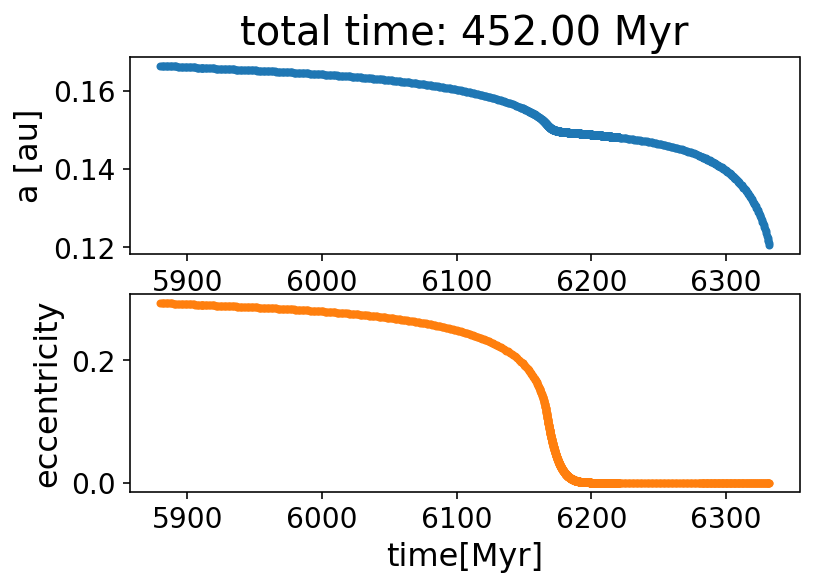

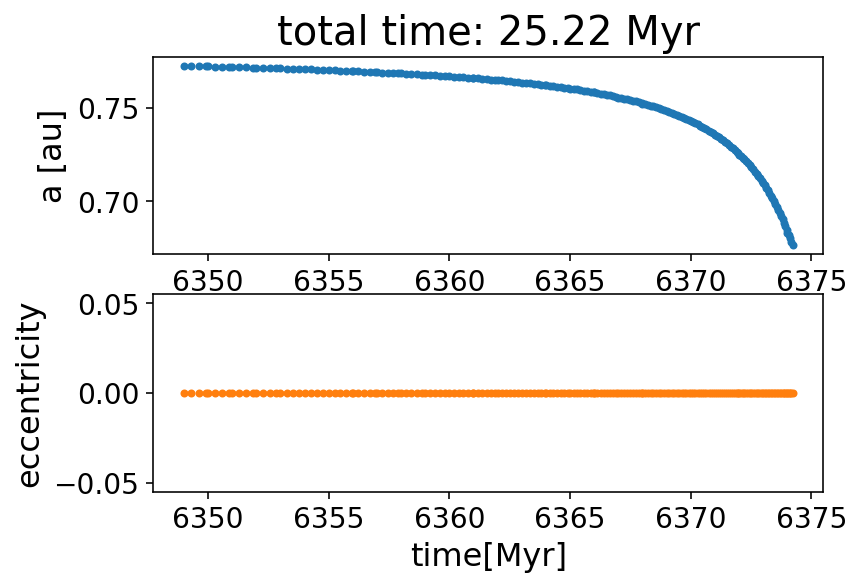

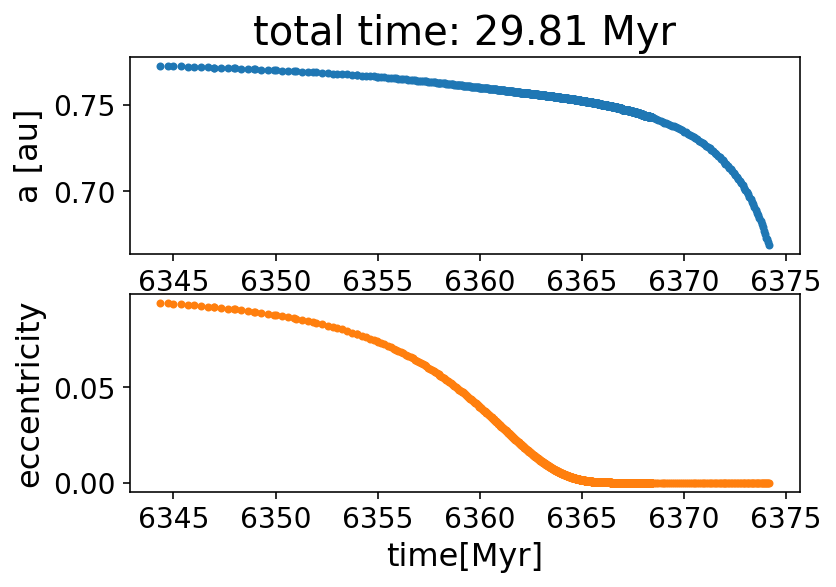

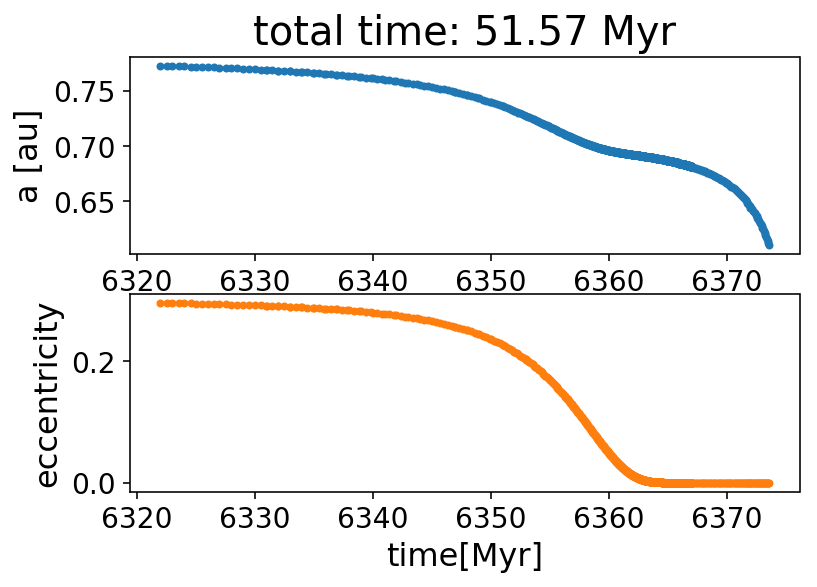

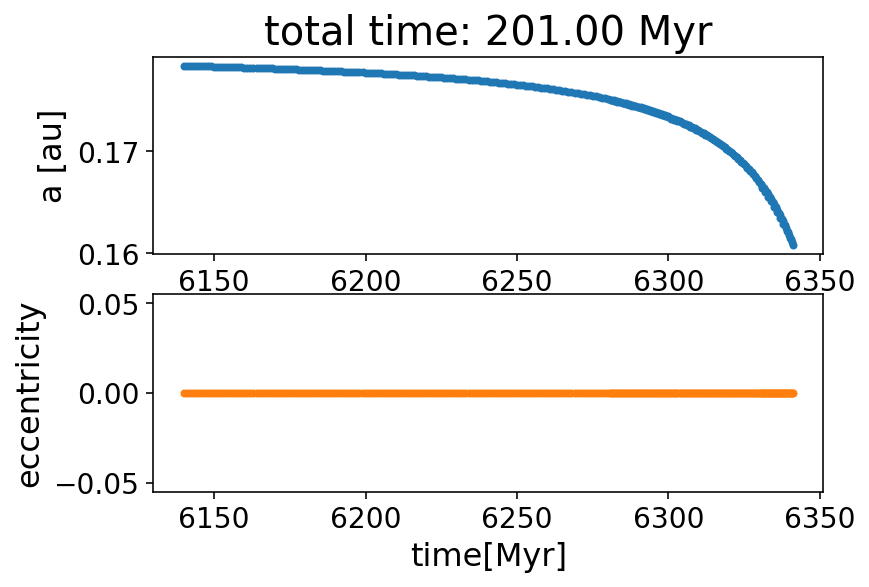

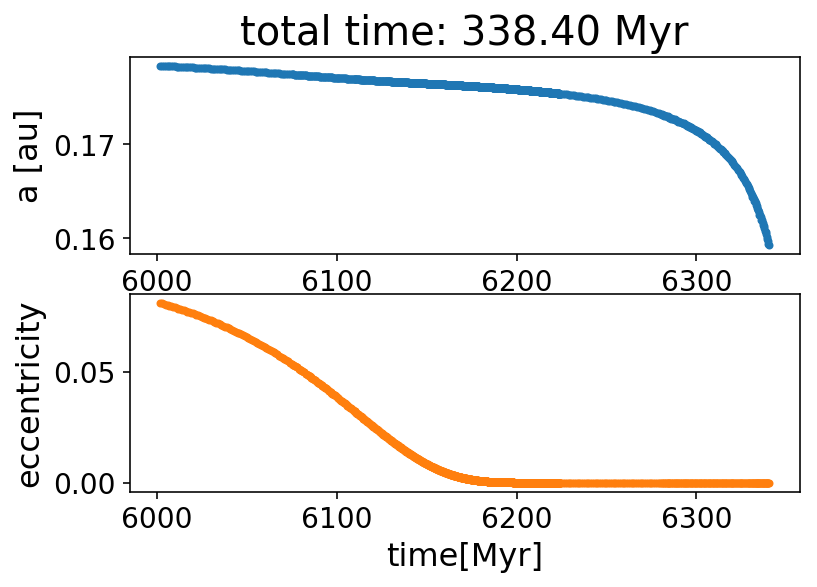

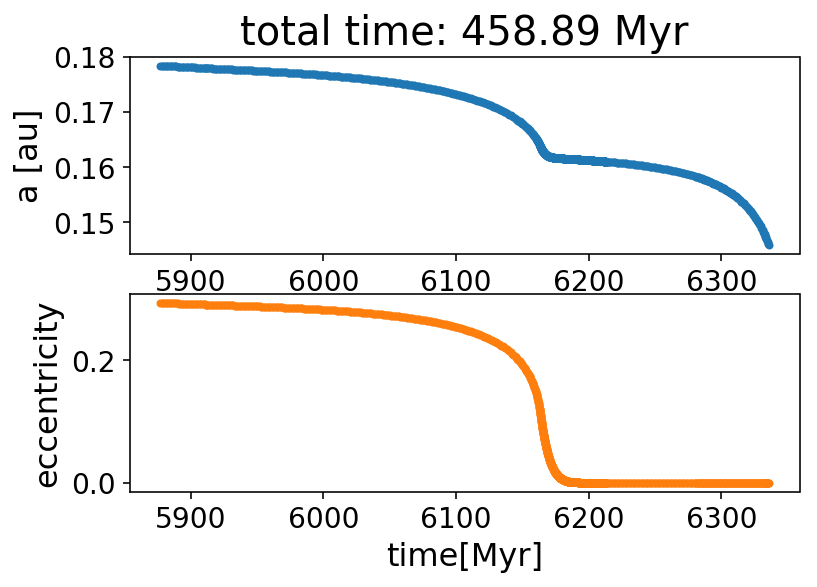

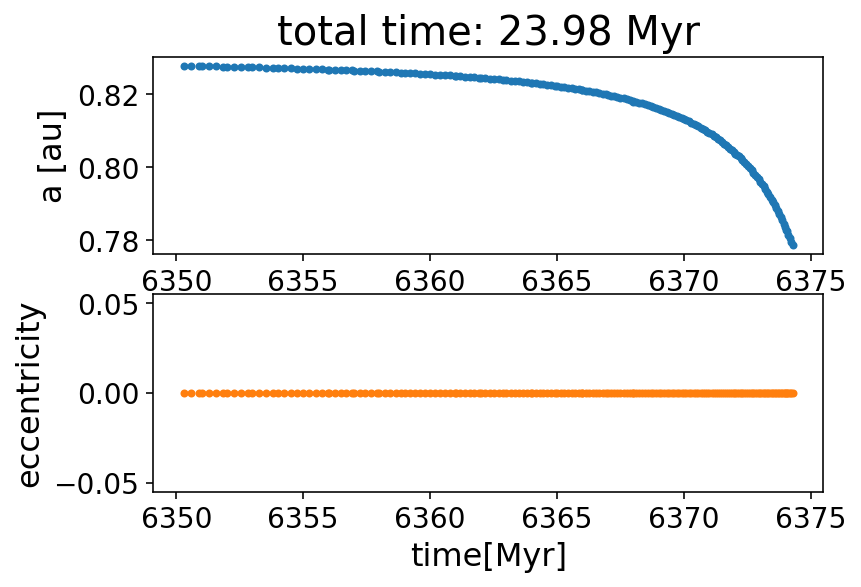

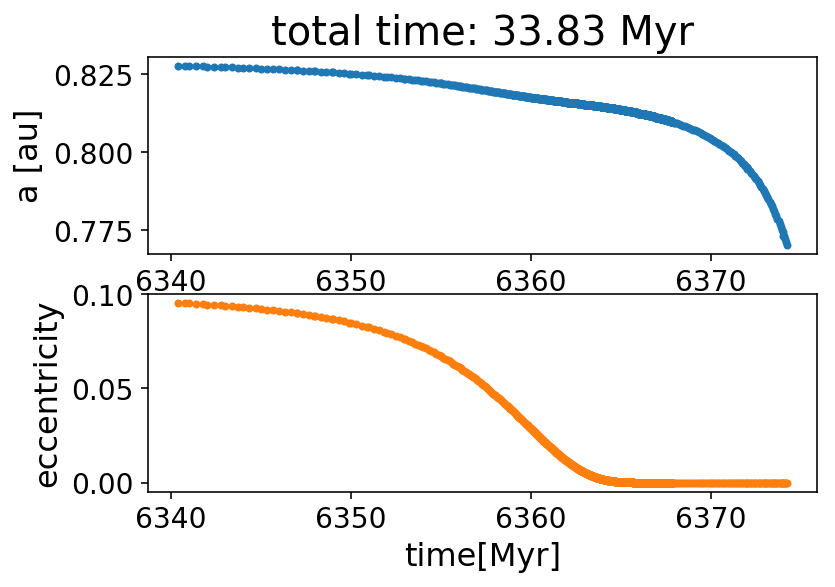

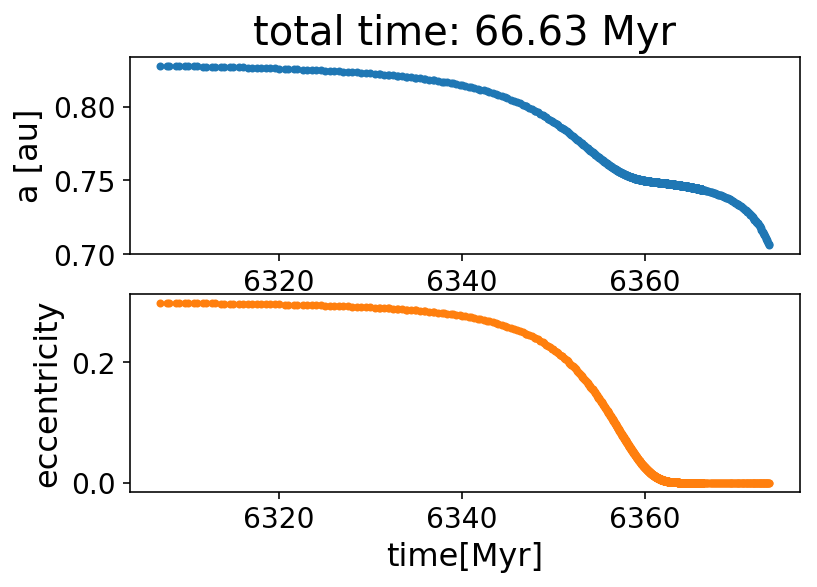

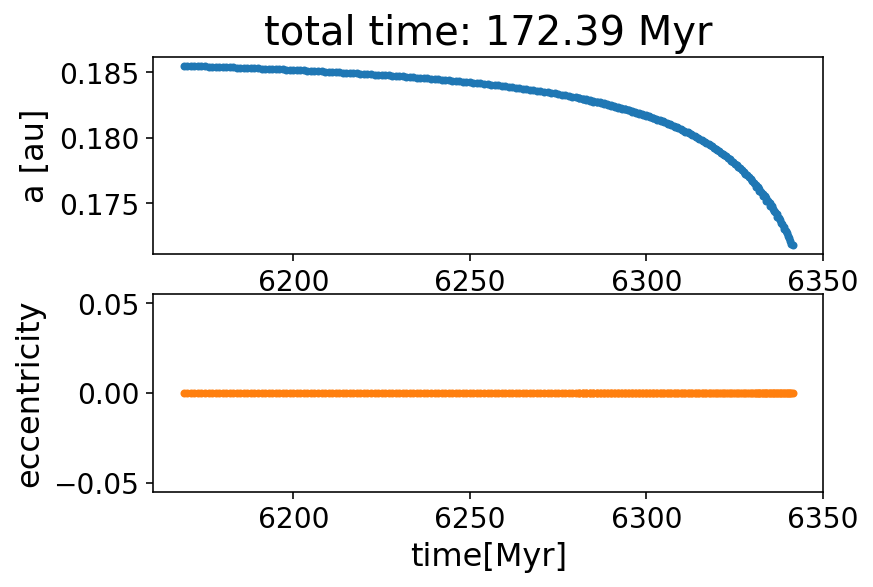

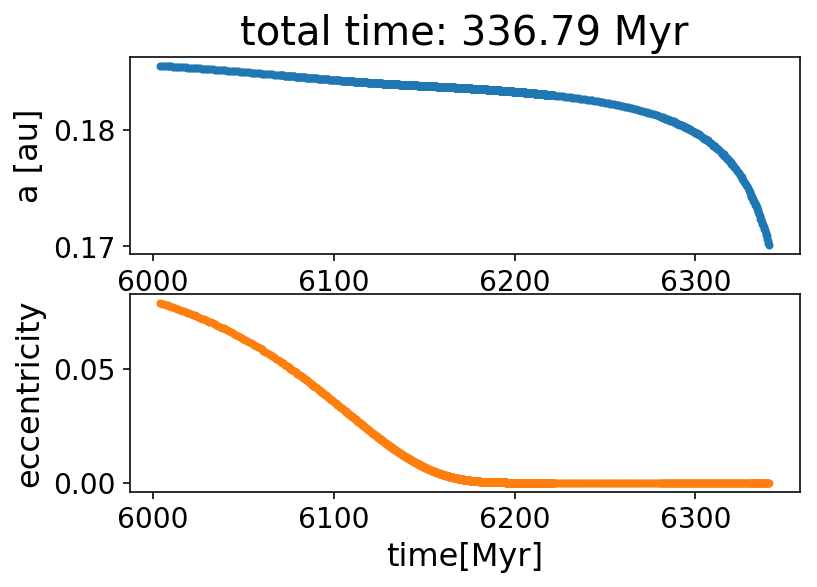

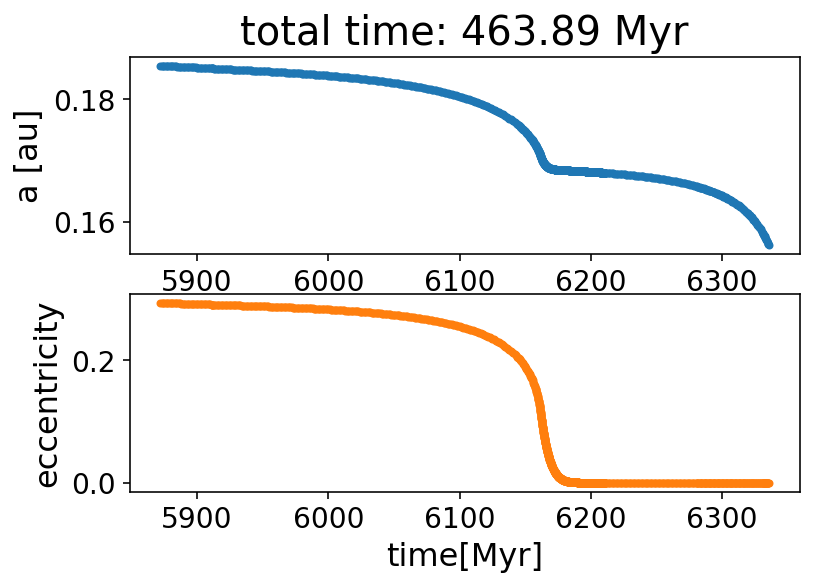

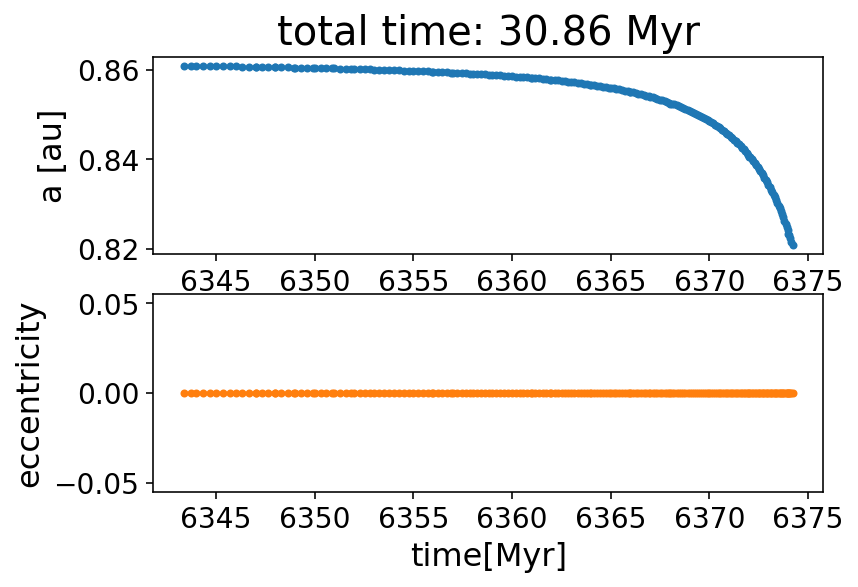

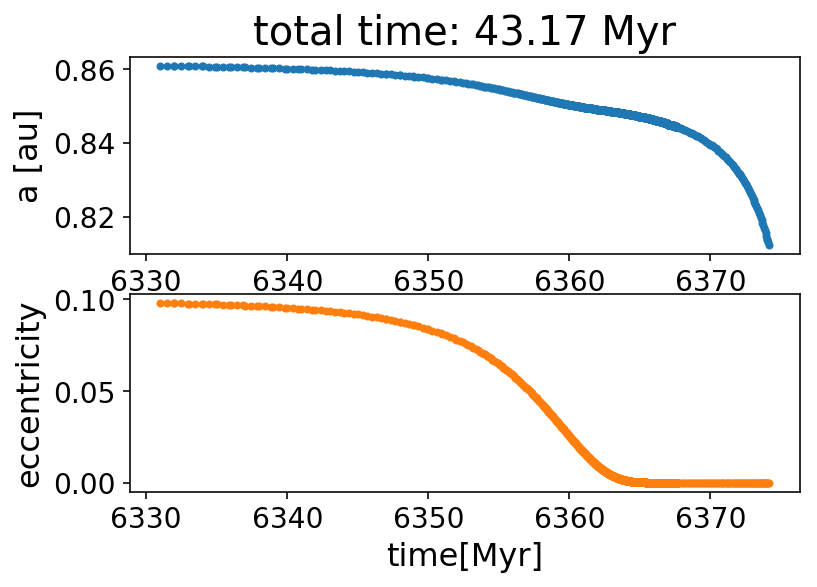

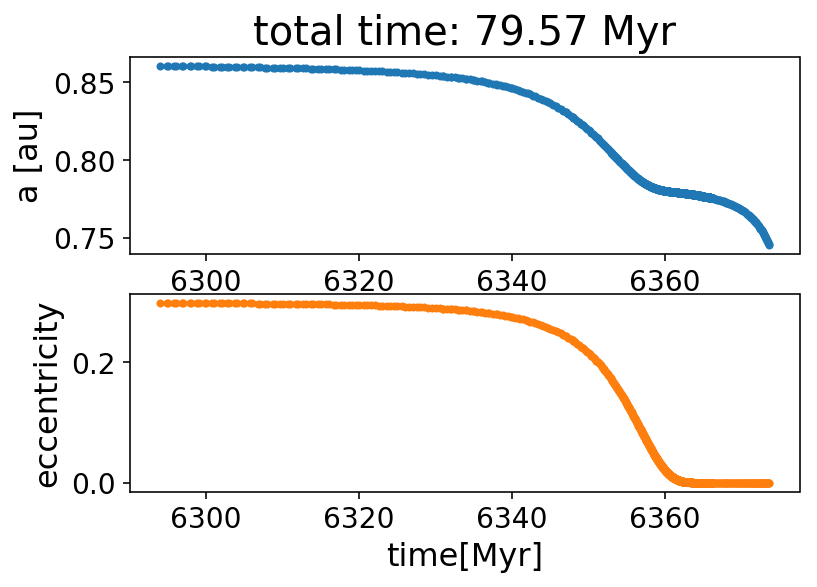

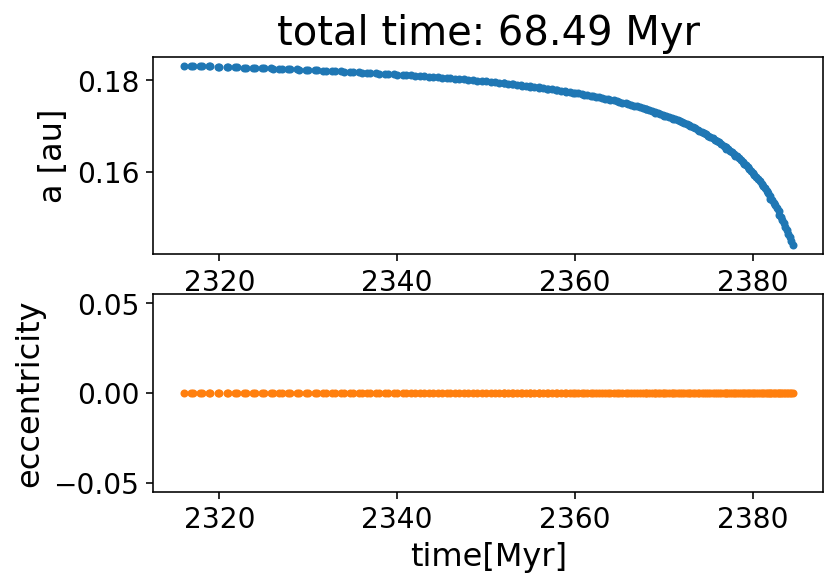

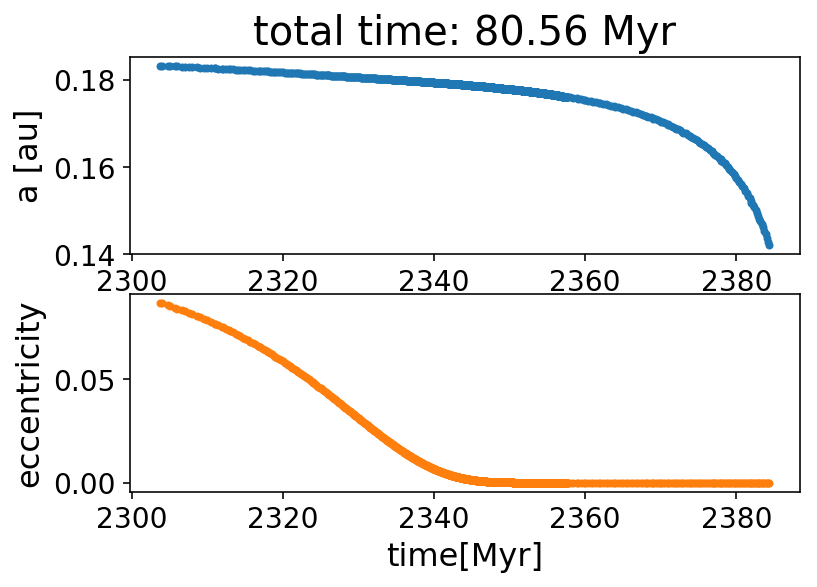

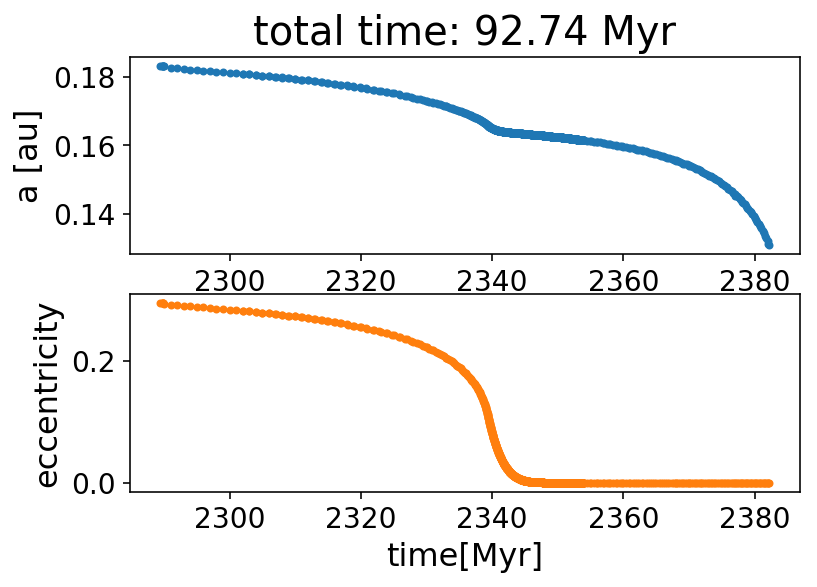

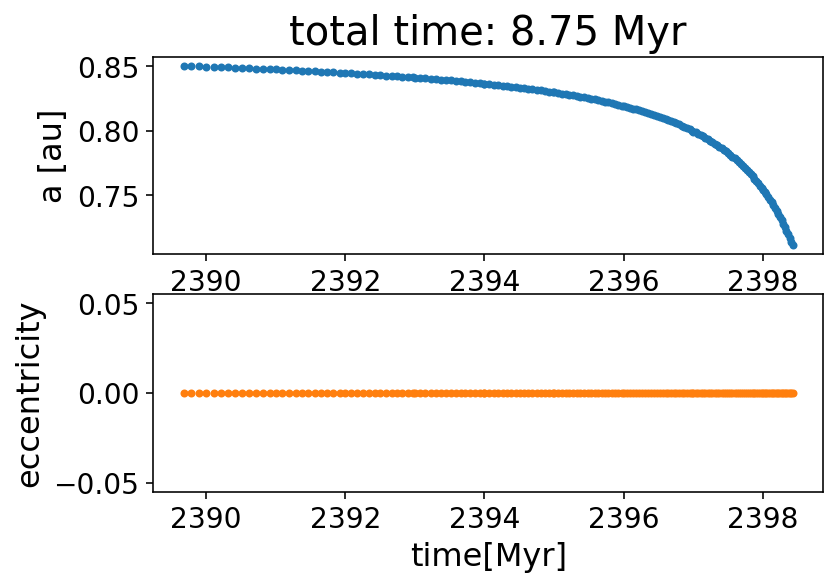

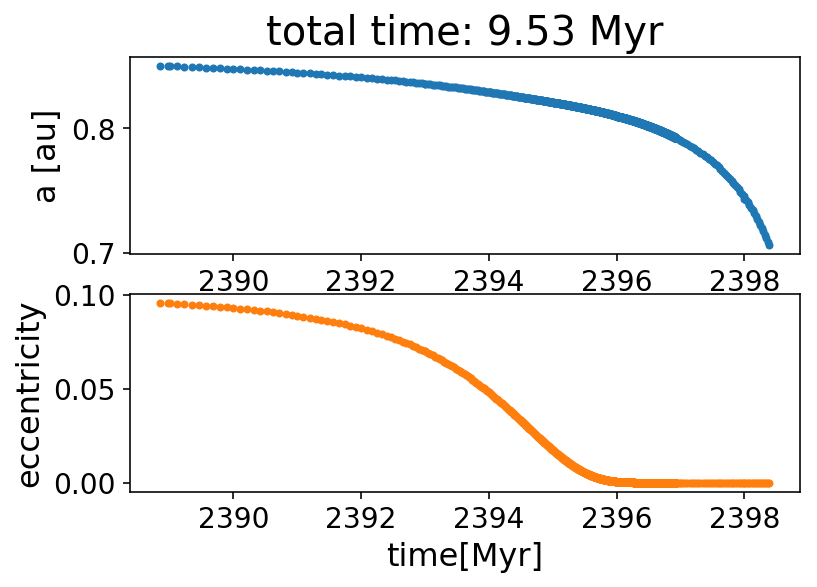

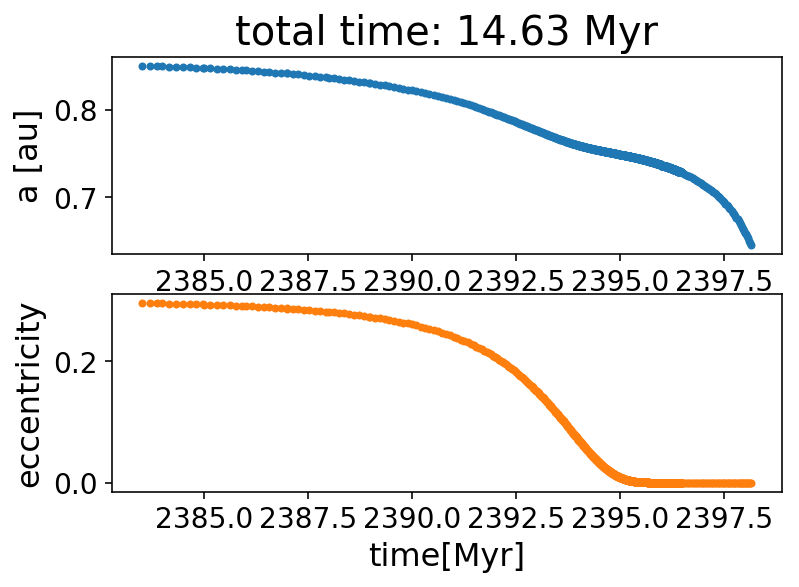

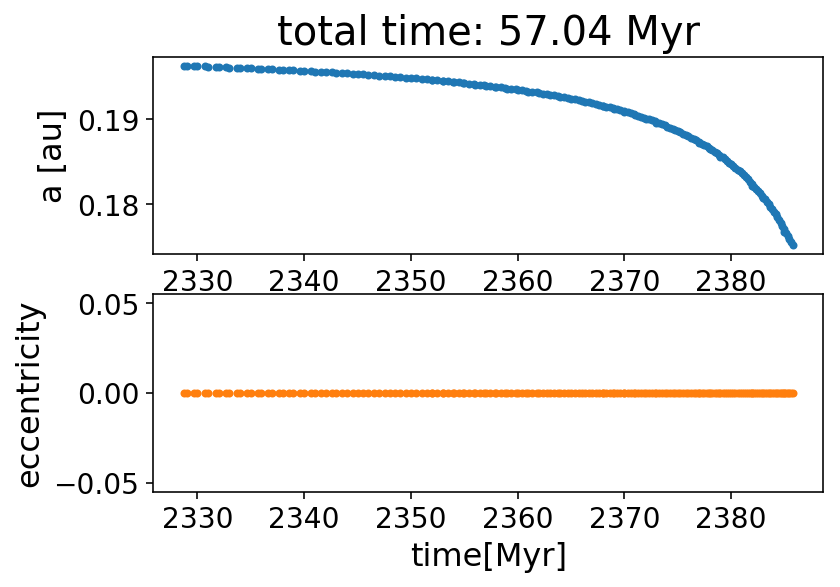

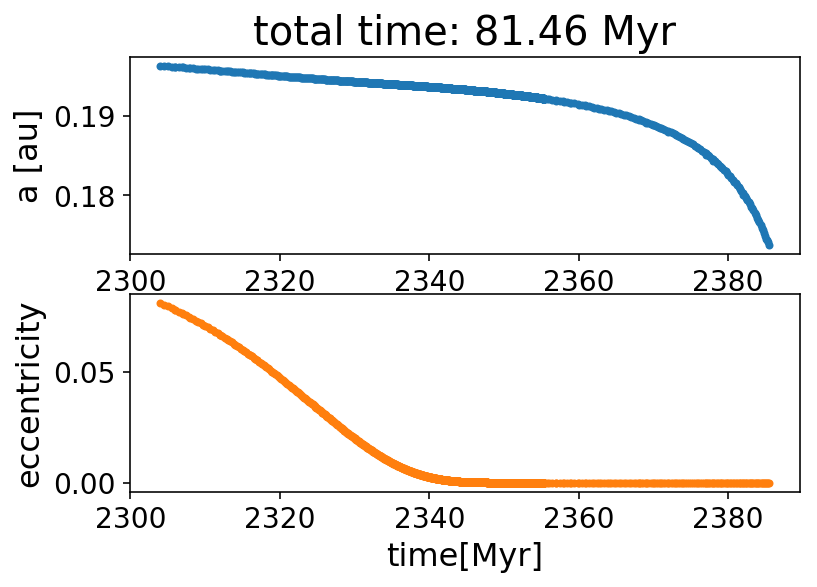

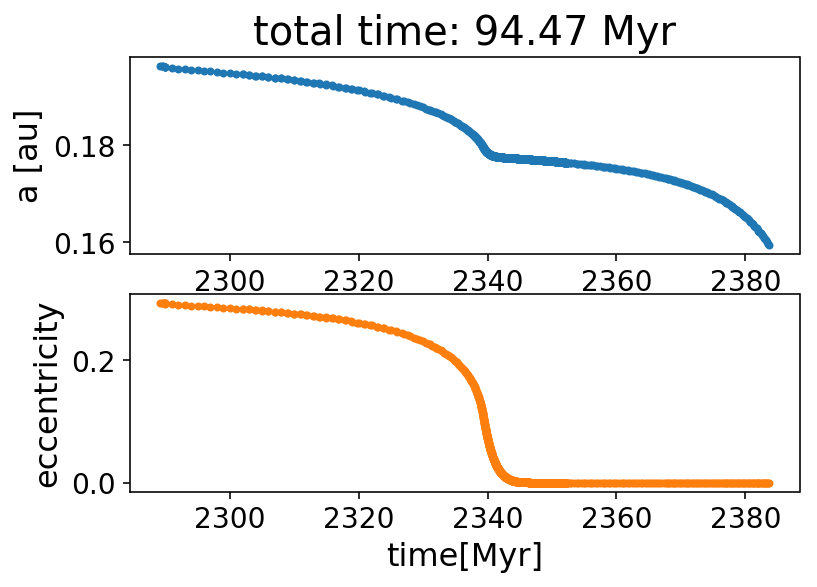

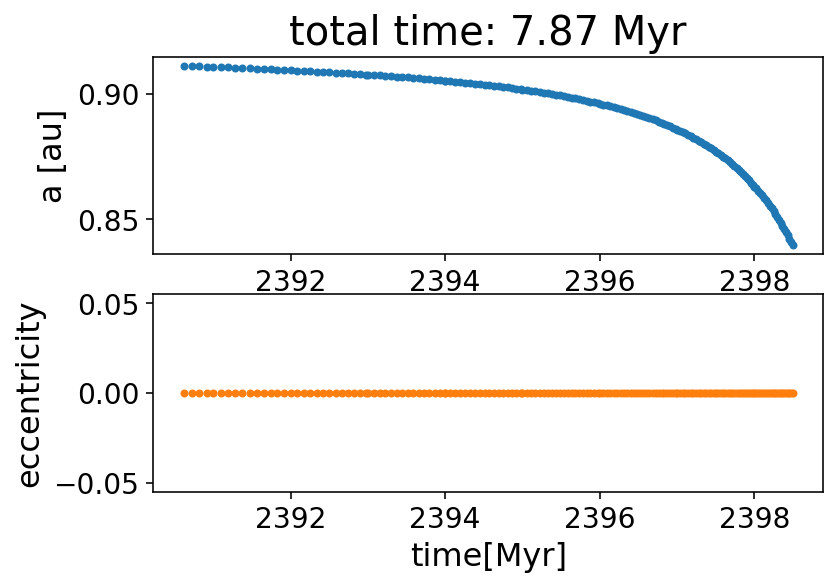

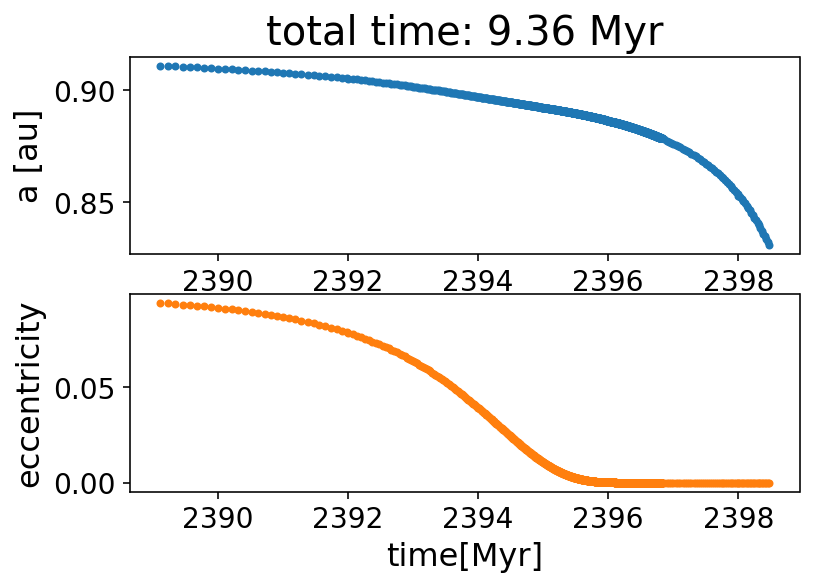

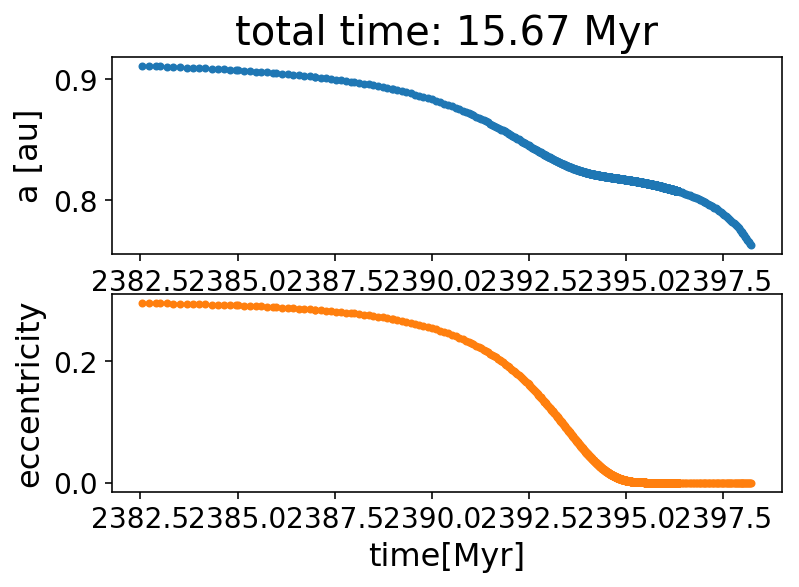

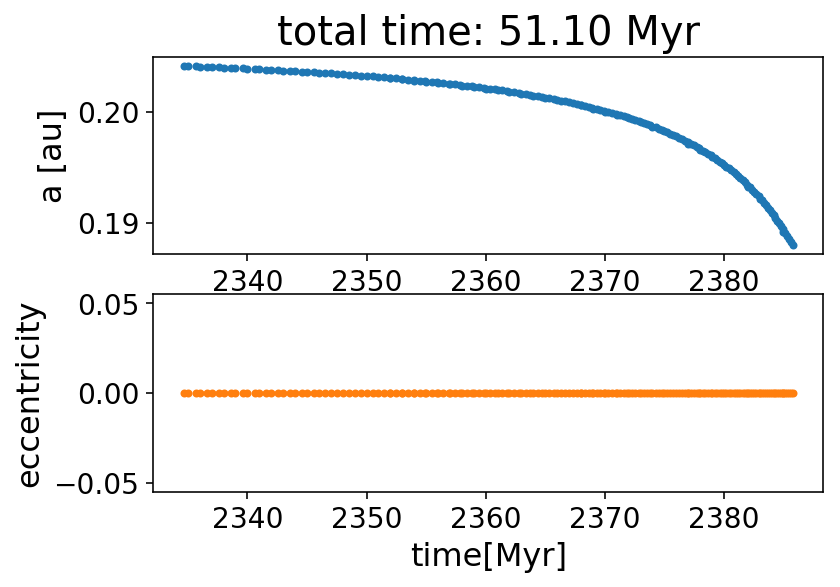

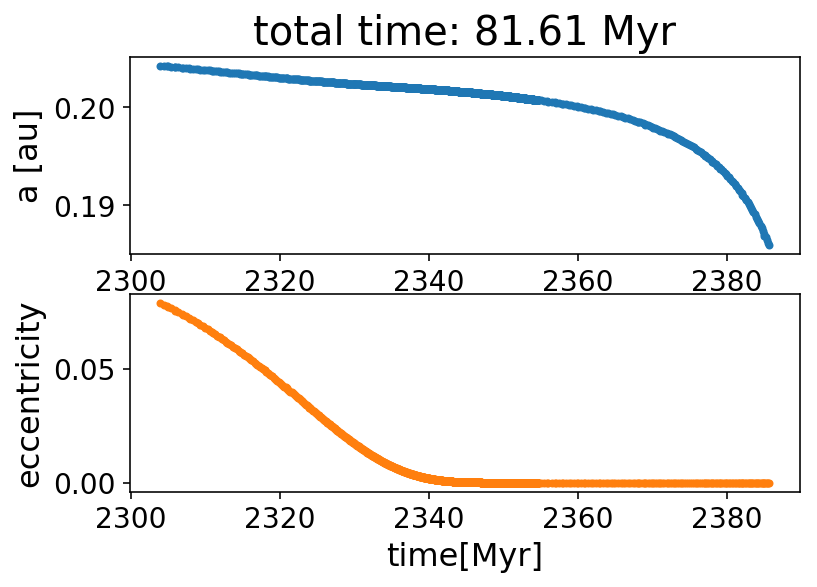

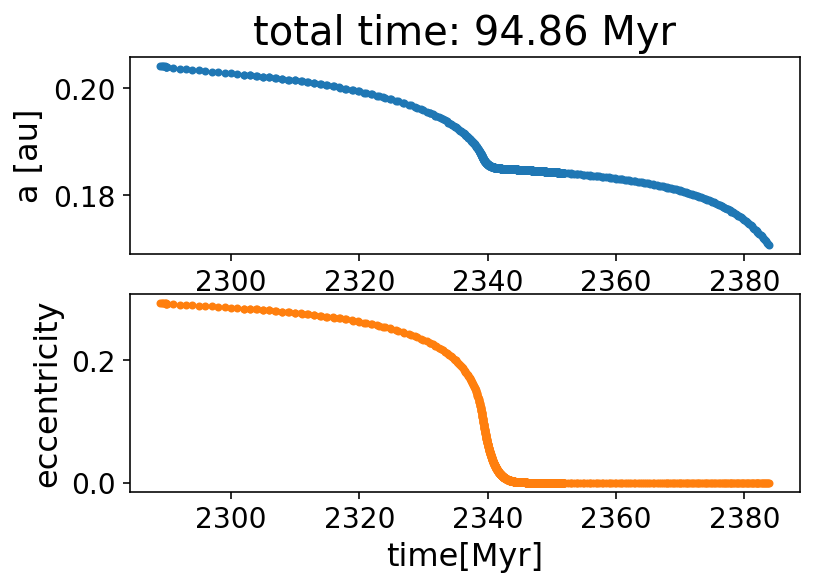

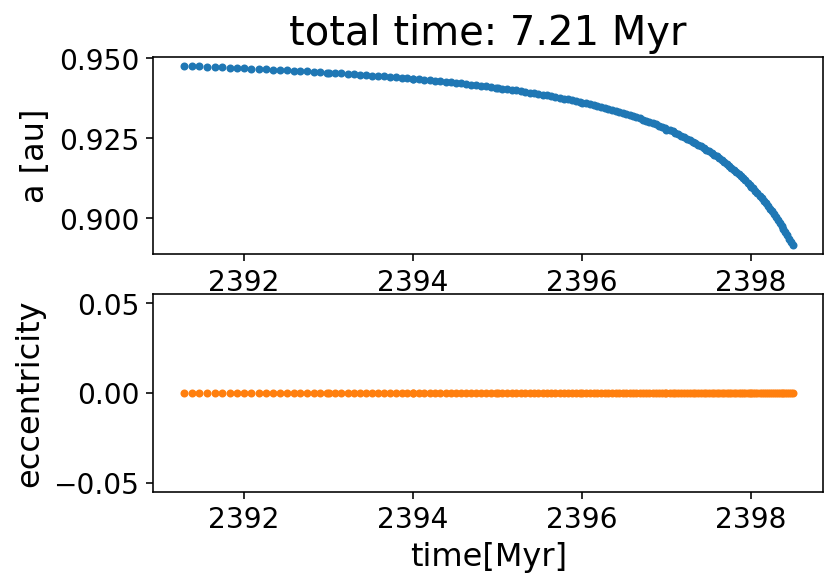

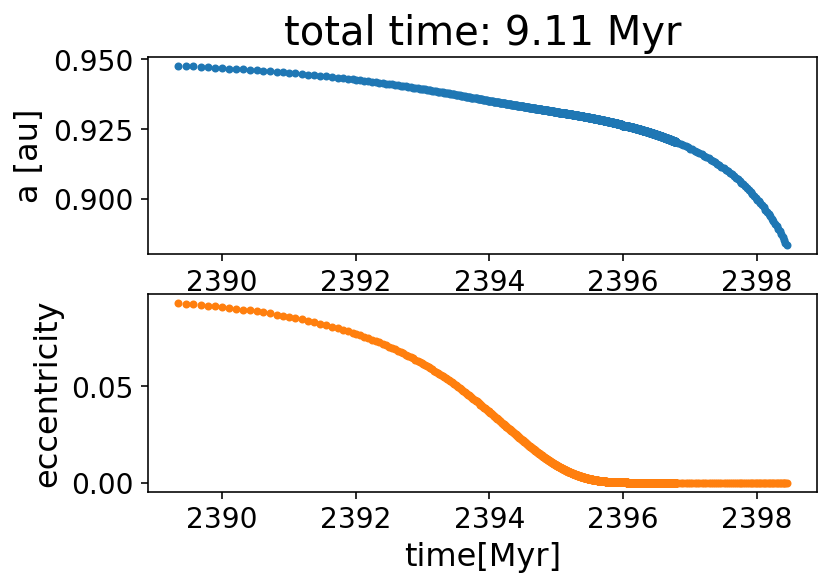

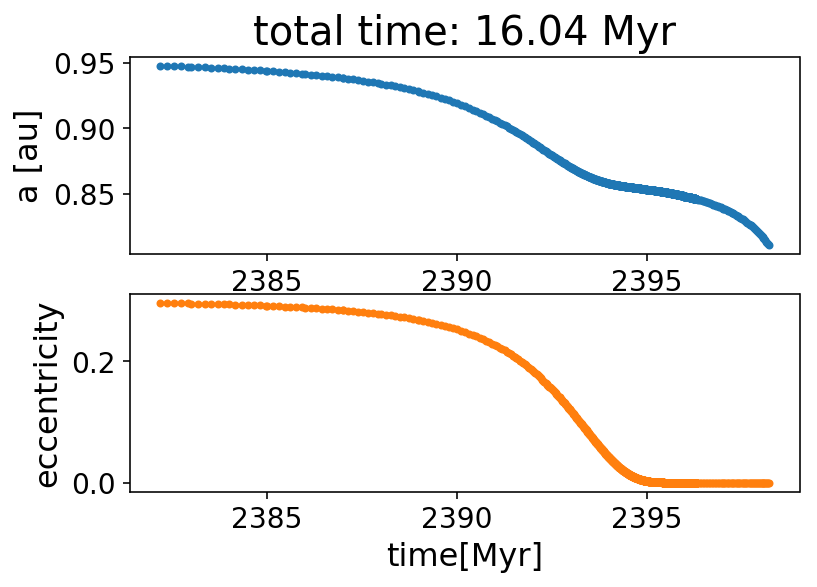

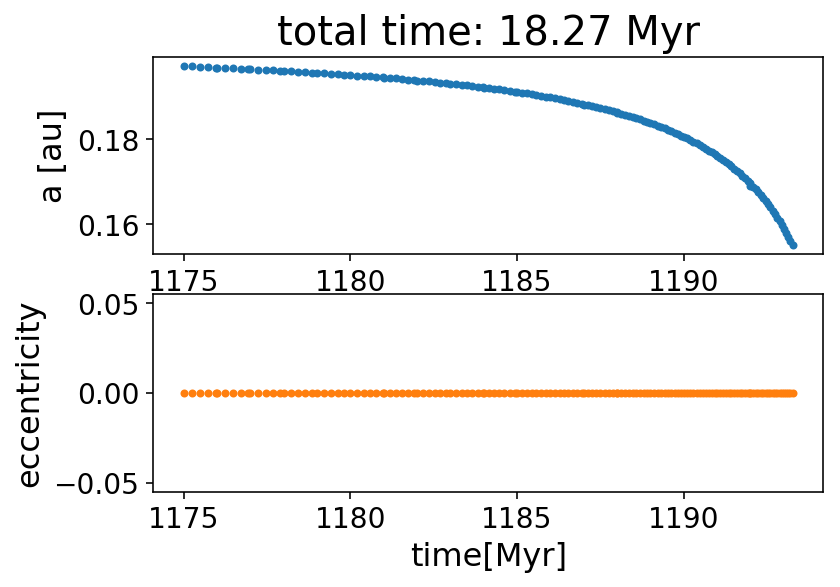

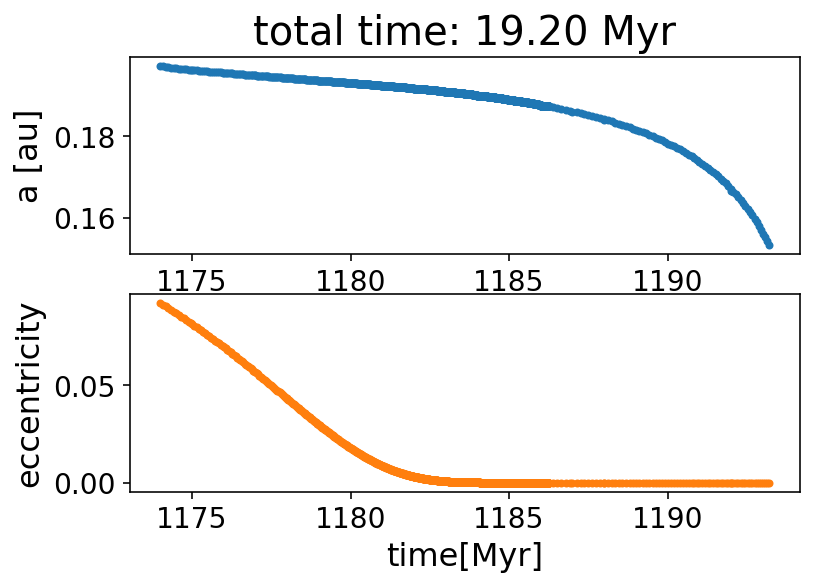

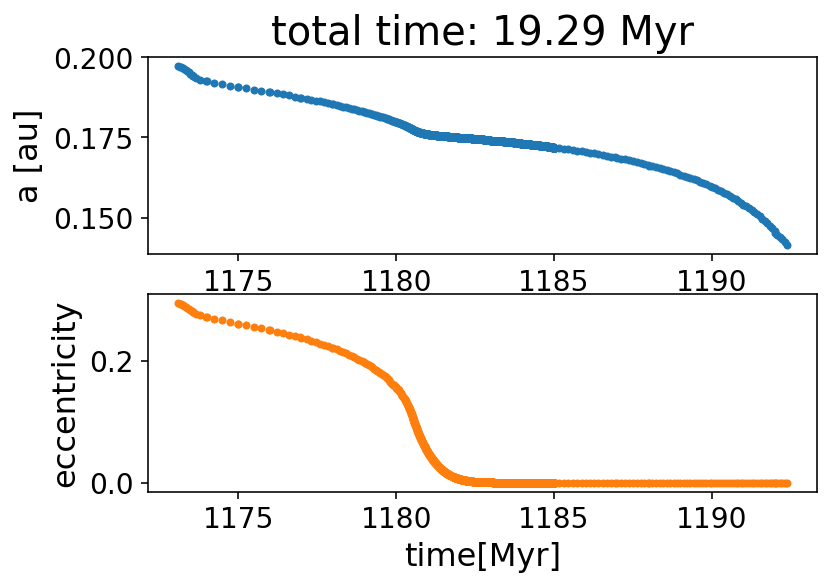

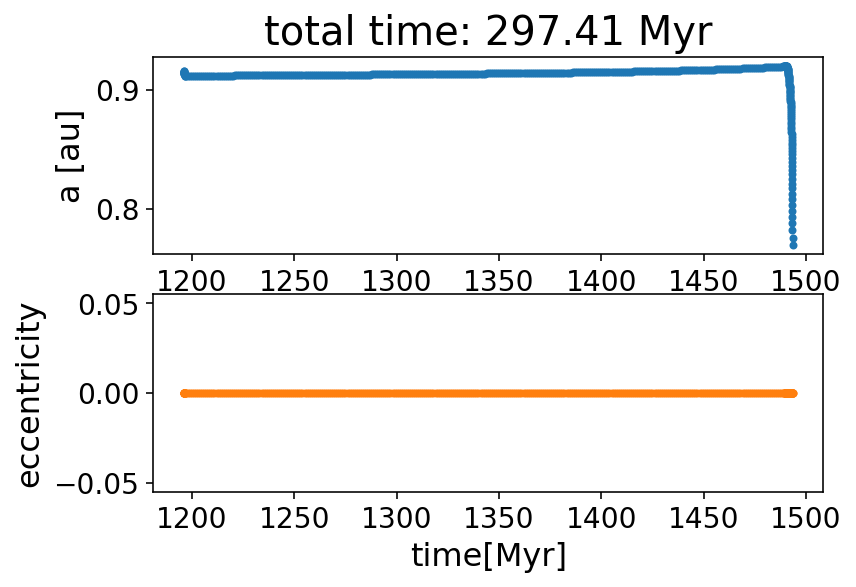

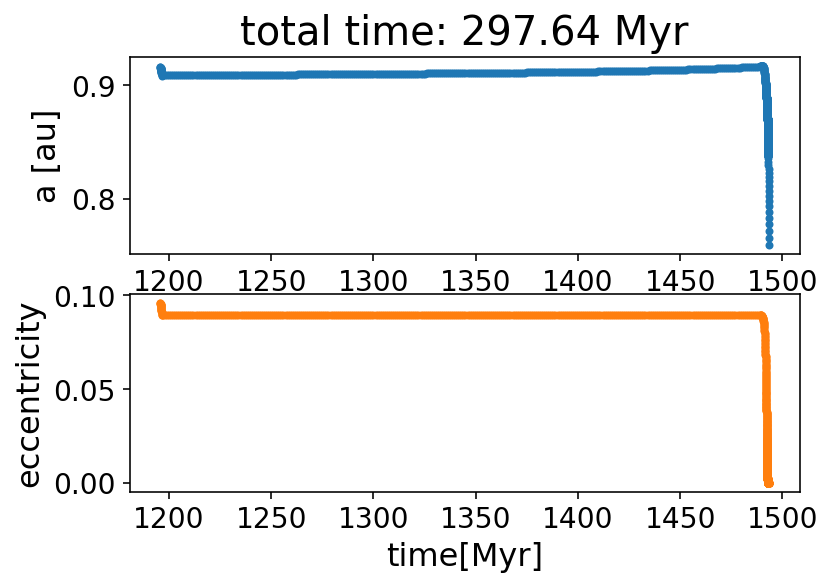

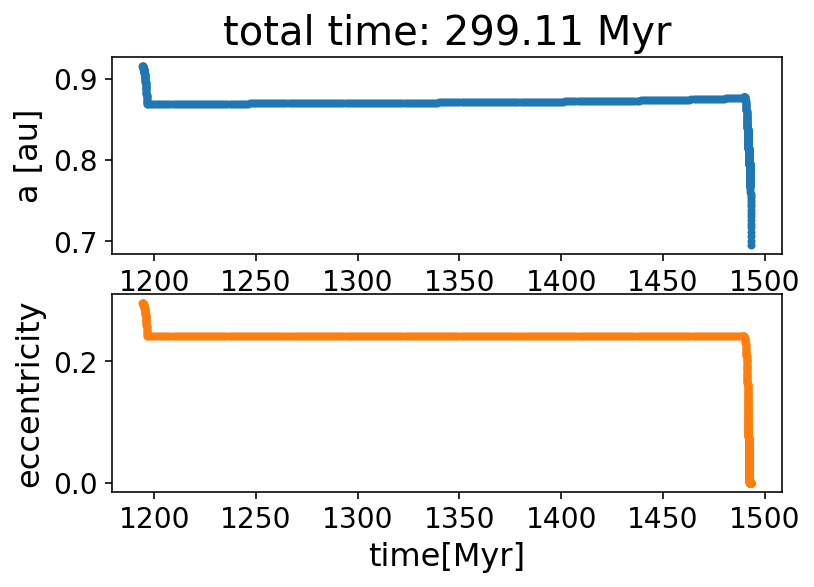

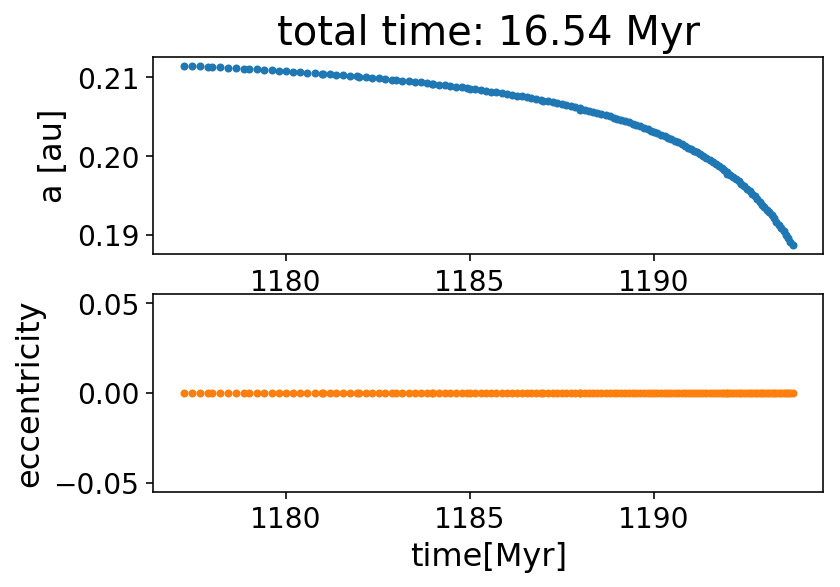

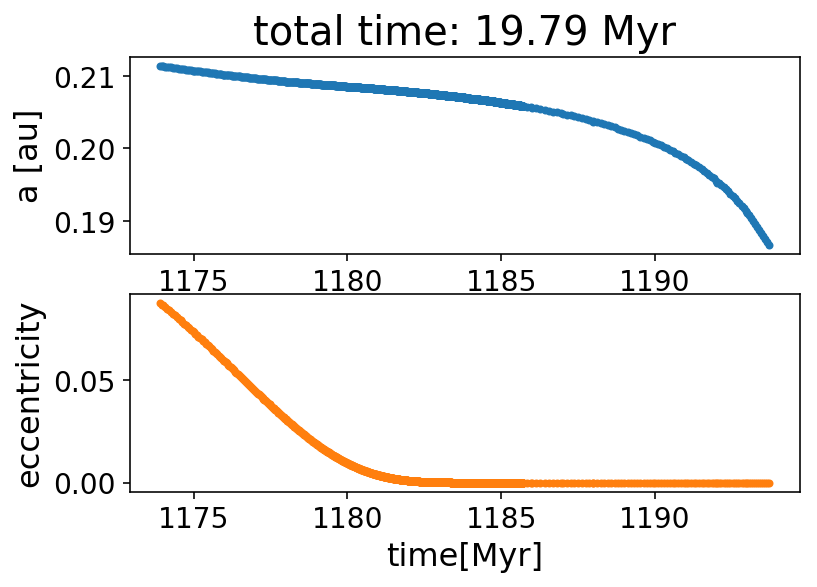

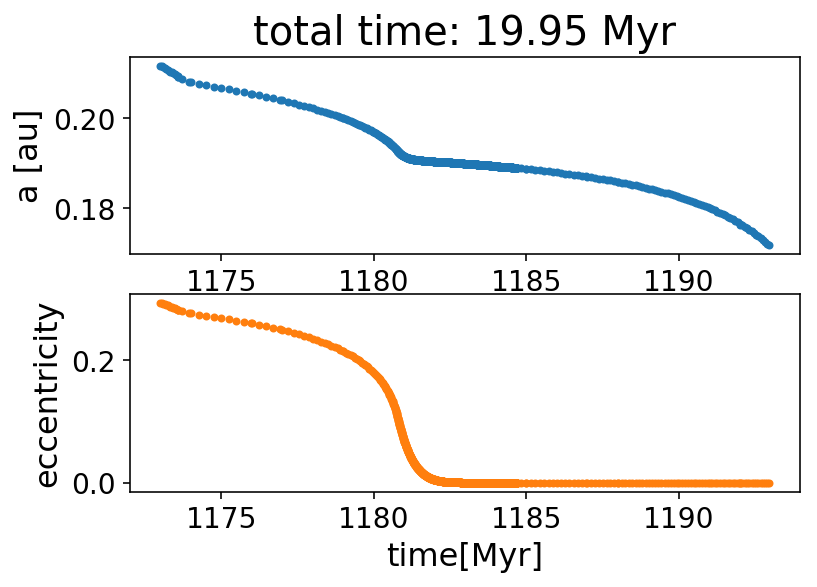

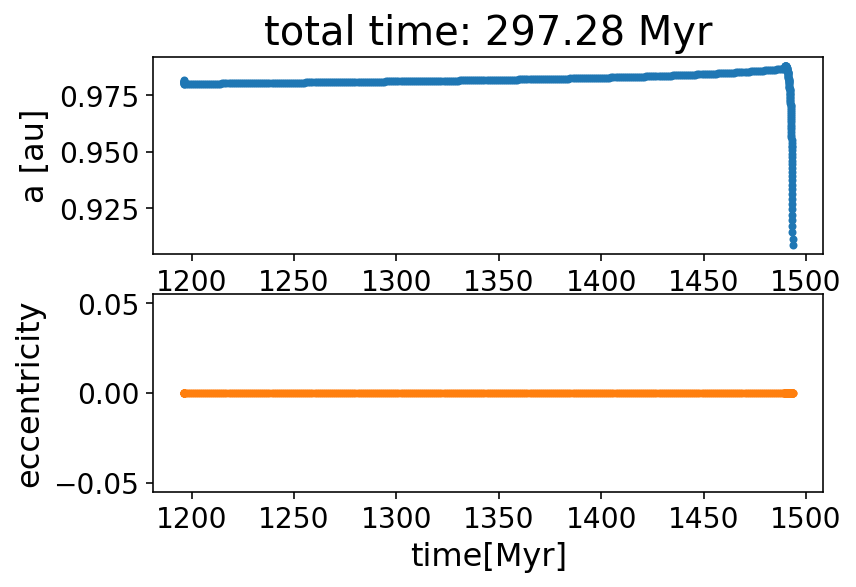

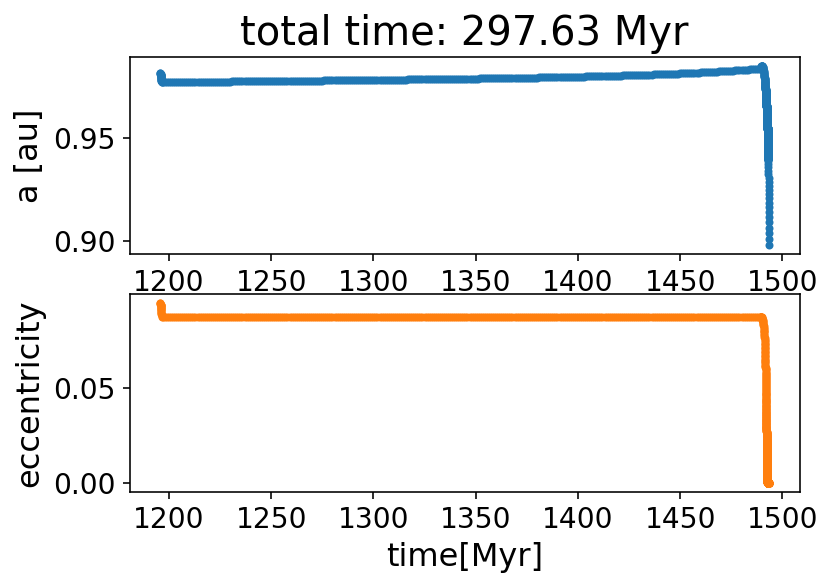

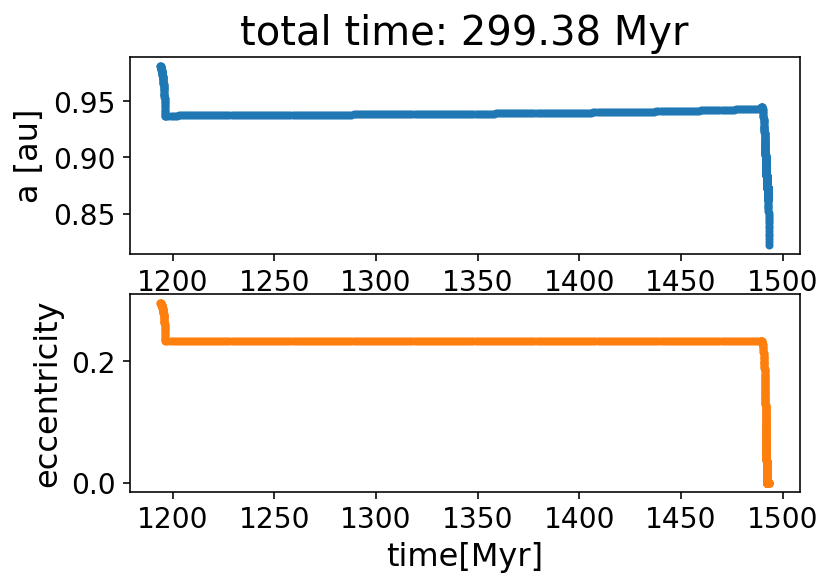

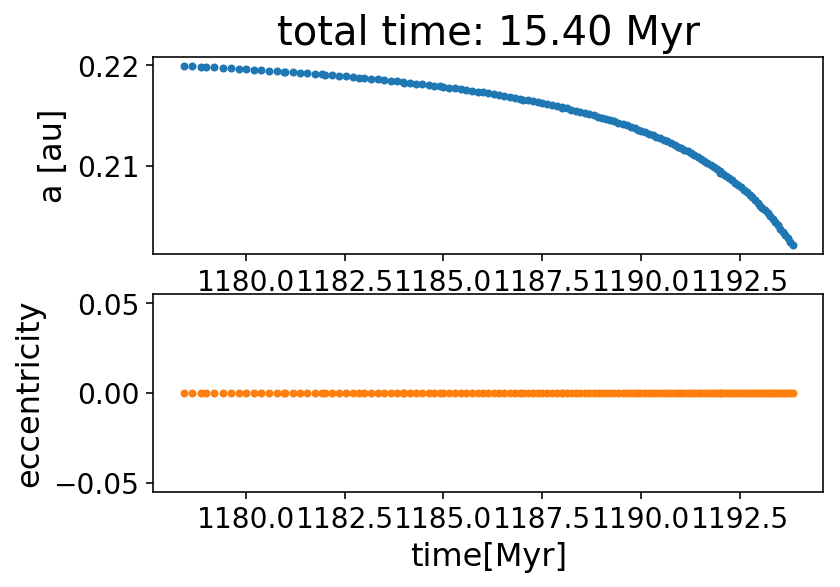

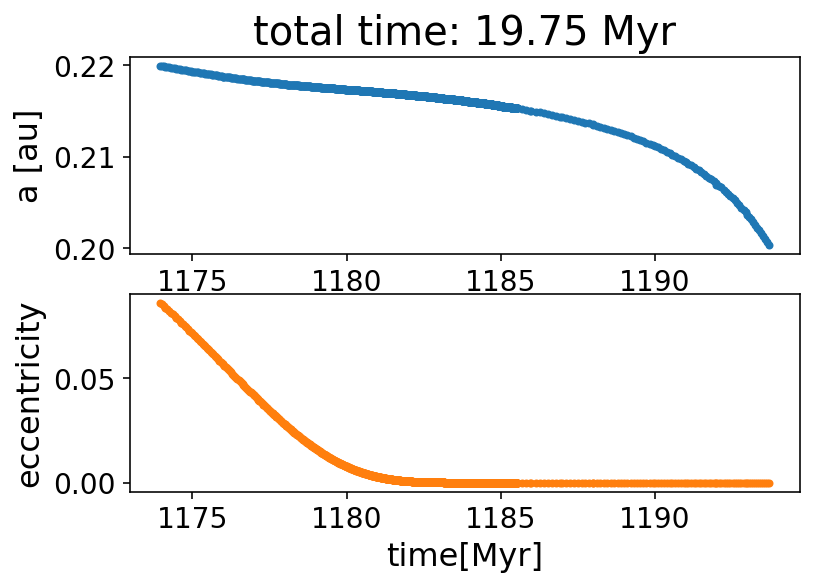

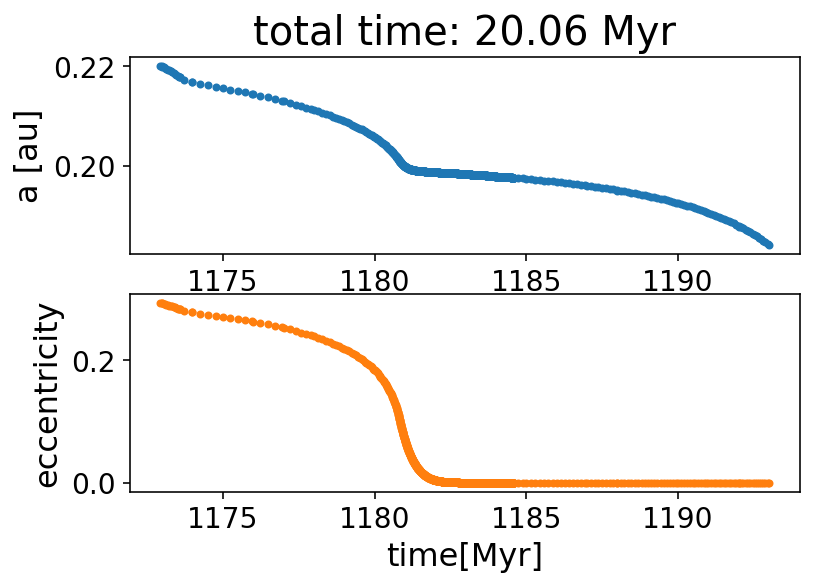

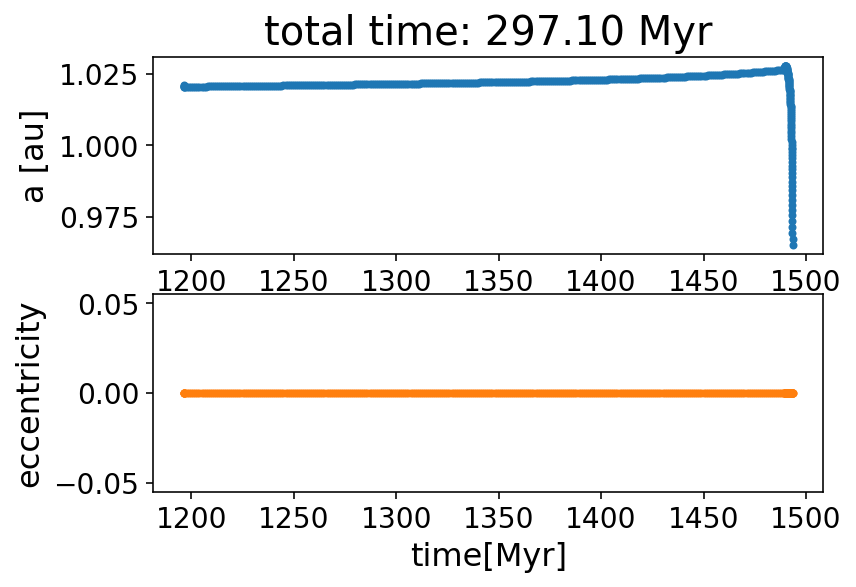

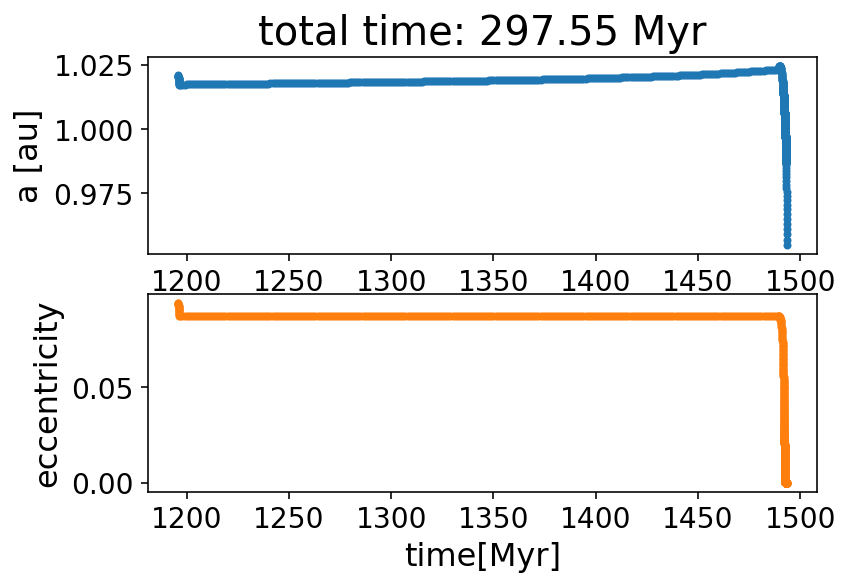

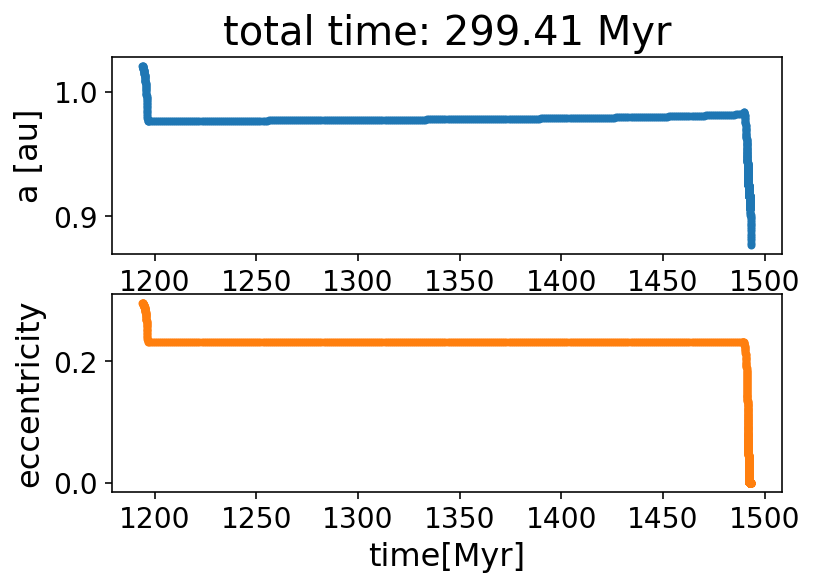

In [10]:
data = evolve_binary(13700, 2.
                           , 1.5, 0.02,
                           300,
                           0.6)
data = select_rgb(data)

data['a'].plot(style=".")


def save_data(df, filename):
    """Saves (t,a,e,M1,M2) from stellar evolution output to file."""
    np.save(filename, df.values)
    # Save a plot of a vs t
    fig, ax = plt.subplots(2)
    ax[0].plot(df['t'], df['a'], 'C0.')
    ax[1].plot(df['t'], df['e'], 'C1.')
    ax[0].set_xlabel('time[Myr]')
    ax[1].set_xlabel('time[Myr]')
    ax[0].set_ylabel('a [au]')
    ax[1].set_ylabel('eccentricity')
    ax[0].set_title('total time: {:.2f} Myr'.format(df['t'].iloc[-1] - df['t'].iloc[0]))
    
    plt.savefig(filename[:-4] + ".pdf")


M1 = np.array([1.2, 1.6, 2.0])
q = [0.3, 0.6, 0.8]
P = [20, 200]
e = [0., 0.1, 0.3]

from itertools import product
for M1_, q_, P_, e_ in product(M1, q, P, e):
    data = evolve_binary(13700, M1_, q_*M1_, 0.02, P_, e_)
    data_rgb = select_rgb(data)
    
    directory = "nbody_sims/{:.1f}_{:.1f}_{:d}_{:.1f}/".format(M1_, q_, P_, e_)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filename = \
    "nbody_sims/{:.1f}_{:.1f}_{:d}_{:.1f}/{:.1f}_{:.1f}_{:d}_{:.1f}.npy"\
        .format(M1_, q_, P_, e_,M1_, q_, P_, e_)
    
    save_data(data_rgb, filename)